In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import random
import sklearn as sk
from time import time
import pickle


In [3]:
face_orig = open("data/facebook-links.txt") 

In [4]:
f_arr = np.array(face_orig.readlines())

In [5]:
G = nx.Graph()

In [6]:
edgelist = []
for line in f_arr: 
    i, j, time = line.split('\t')
    edgelist.append((int(i), int(j)))

In [7]:
G.add_edges_from(edgelist)

### Graph splitter 

In [8]:
def split_graph(G, alpha_v, save_as=""):
    V = np.array(G.nodes())
    random.shuffle(V)
    a = int((1-alpha_v)/2 * len(V))
    b = int(alpha_v * len(V))
    Va = V[:a]
    Vb =  V[a:a+b]
    Vc =  V[a+b:2*a+b]
    V1 = np.concatenate((Va, Vb))
    V2 = np.concatenate((Vb, Vc))
    G1 = G.subgraph(V1)
    G2 = G.subgraph(V2)
    if save_as != '': 
        nx.write_edgelist(G1, 'data/'+str(alpha_v)+save_as+'_aux.edgelist')
        nx.write_edgelist(G2, 'data/'+str(alpha_v)+save_as+'_san.edgelist')
    return G1, G2

In [9]:
G1, G2 = split_graph(G, 0.25)

In [11]:
## Apply anonimization

In [10]:
def anonimize(G):
    return G

In [12]:
G_aux = anonimize(G1)
G_san = anonimize(G2)

### Generating training data

In [16]:
G_a1, G_a2 = split_graph(G_aux, 0.25) # aux 
G_s1, G_s2 = split_graph(G_san, 0.25) # sanitized

In [99]:
def deg_dist(G, n, bins, size):
    feature_set = [0 for i in range(2*bins)]
    _1hop = G[n]
    _1hop = G.degree(_1hop).values()
    for h in _1hop:
        if h < bins*size:
            feature_set[int(h/size)] += 1
    _prev = set(nx.single_source_shortest_path_length(G, n, cutoff=1).keys())
    _2hop = set(nx.single_source_shortest_path_length(G, n, cutoff=2).keys())
    _2hop = _2hop - _prev
    _2hop = G.degree(_2hop).values()
    for h in _2hop:
        if h < bins*size:
            feature_set[bins+int(h/size)] += 1
    return feature_set
    
def feature(G1, n, G2, m,  bins = 21, size = 50):
    feature_set = [0 for i in range(4*bins)]
    f_set = deg_dist(G1, n, bins, size)
    for i in range(len(f_set)):
        feature_set[i] += f_set[i]
    f_set = deg_dist(G2, m, bins, size)
    for i in range(len(f_set)):
        feature_set[2*bins+i] += f_set[i]
    # the Silhouette Coefficient 
    n_deg = G1.degree(n)
    m_deg = G2.degree(m)
    feature_set.append(abs(n_deg-m_deg)/max(n_deg, m_deg, 1))
    return feature_set

def fill_set(G1, G2, data, labels):
    indx = 0
    total = len(G1.nodes())
    # report every 10 % 
    part = total//10
    for i in G1.nodes():
        if i in G2.nodes():
            # There is an intersection
            data.append(feature(G1, i, G2, i))
            labels.append(1)
        else:
            # Choose randomly 
            j = random.choice(list(set(G2.nodes())-set([i])))
            data.append(feature(G1, i, G2, j))
            labels.append(0)
        indx += 1
        if indx % part ==0:
            print("Finished : " + str(indx/total))

In [93]:
train_set = []
train_labels = []
s = time()
print("Dataset is generating ... ")
fill_set(G_a1, G_a2, train_set, train_labels)
e = time()
print("Aux finished " + str(e-s) + " sec")
s = time()
fill_set(G_s1, G_s2, train_set, train_labels)
e = time()
print("San finished " + str(e-s) + " sec")
pickle.dump( (train_set, train_labels), open( "data/train_face.set", "wb" ) )

Dataset is generating ... 
Aux finished -252.8912250995636 sec
San finished -284.2667410373688 sec


In [100]:
test_set = []
test_labels = []
s = time()
print("Dataset is generating ... ")
fill_set(G_aux, G_san, test_set, test_labels)
e = time()
print("Test set generated in  " + str(e-s) + " sec")
pickle.dump( (test_set, test_labels), open( "data/test_face.set", "wb" ) )

Dataset is generating ... 
Finished : 0.09999748939268409
Finished : 0.19999497878536818
Finished : 0.29999246817805225
Finished : 0.39998995757073635
Finished : 0.49998744696342046
Finished : 0.5999849363561045
Finished : 0.6999824257487887
Finished : 0.7999799151414727
Finished : 0.8999774045341569
Finished : 0.9999748939268409
Test set generated in  814.7160470485687 sec


In [105]:
forest = RandomForestClassifier(n_estimators = 400, n_jobs=4)

In [106]:
forest.fit(train_set, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=4,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [109]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
ada = RandomForestClassifier(n_estimators = 400, n_jobs=4)

In [120]:
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),
                         n_estimators=400)

In [121]:
ada.fit(train_set, train_labels)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.0, n_estimators=400, random_state=None)

In [122]:
ada.score(test_set, test_labels)

0.81820692425497732

In [107]:
forest.score(test_set, test_labels)

0.82792297456754793

In [123]:
from sklearn.ensemble import GradientBoostingClassifier

In [124]:
gbc = GradientBoostingClassifier(n_estimators=100)

In [125]:
gbc.fit(train_set, train_labels)
gbc.score(test_set, test_labels)

0.82556300369059277

In [4]:
train_set, train_labels = pickle.load(open( "data/train_face.set", "rb" ) )

In [11]:
test_set,  test_labels = pickle.load(open( "data/test_face.set", "rb" ) )

In [27]:
from sklearn import svm, datasets
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score as cv

parameters = {'criterion':['gini'], 'n_estimators':[400], 'bootstrap':['true'], 'max_features':['auto']}
svr = RandomForestClassifier(n_jobs=-1)
print('Staring gridSearch ... ')
clf = GridSearchCV(svr, parameters)
clf.fit(train_set, train_labels)

Staring gridSearch ... 


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': ['auto'], 'criterion': ['gini'], 'n_estimators': [400], 'bootstrap': ['true']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [25]:
clf.best_estimator_

RandomForestClassifier(bootstrap='true', class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [28]:
clf.score(test_set, test_labels)

0.82767191383595695

In [54]:
from sklearn.metrics import roc_curve, auc

In [57]:
y_score = clf.predict(test_set)

In [66]:
y_true = test_labels
fpr, tpr, thresholds = roc_curve(y_true, y_score[:, 1])

In [67]:
roc_auc = auc(fpr, tpr)

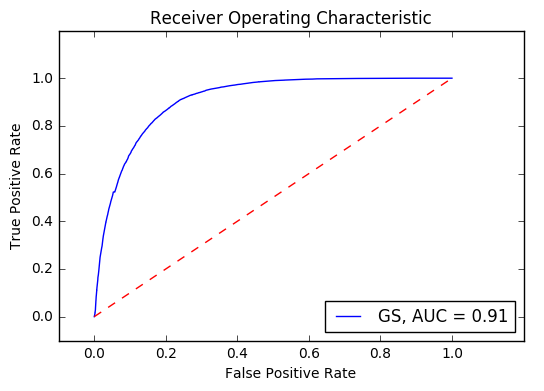

In [68]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',
label='GS, AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()